In [2]:
# ライブラリのインポート
import pandas as pd
import matplotlib.pyplot as pyplot
% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn

# CSVファイルからDataFrameへロード
original_df = pd.read_csv('No-show-Issue-Comma-300k.csv')
original_df.head(6)

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6
5,5,F,2014-06-17T06:47:27Z,2014-07-22T00:00:00Z,Tuesday,No-Show,0,0,0,0,0,0,0,1,-35


In [3]:
original_df['Status'].value_counts()

Show-Up    209269
No-Show     90731
Name: Status, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1ba6fc18>,
      dtype=object)

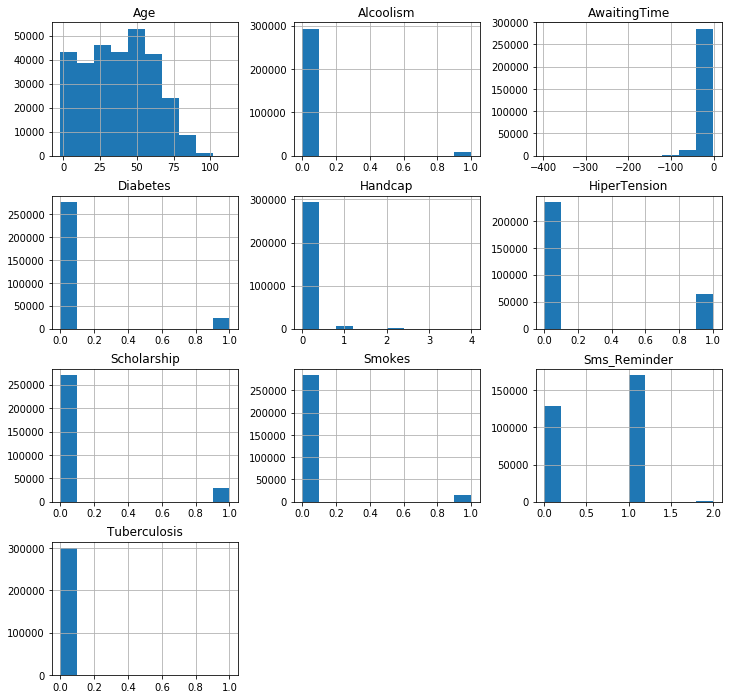

In [4]:
original_df.hist(figsize=(12, 12))

In [5]:
#経時的な変化は無いか？　→なさそう(12月だけちょっと多いか)
appointments = pd.DataFrame(index=original_df.index)
appointments['AppointmentDate'] = pd.to_datetime(original_df['ApointmentData']).apply(lambda a: '{}/{:02}'.format(a.year, a.month))
appointments['NoShow'] = original_df['Status'].apply(lambda d: 1 if d == 'No-Show' else 0)

In [6]:
temp = pd.DataFrame(appointments.groupby('AppointmentDate').count())
temp['ALL'] = appointments.groupby('AppointmentDate').count()
temp['Noshow'] = appointments.groupby('AppointmentDate').sum()
temp.reset_index(inplace = True)
#plt.plot(temp.index, temp['All'])
#plt.plot(temp.index, temp['NoShow'])
#plt.show()

In [7]:
#目的変数と説明変数の抽出
features_df = pd.DataFrame()

#目的変数の抽出(No-Showなら1)
features_df['Outcome'] = original_df['Status'].apply(lambda s: 1 if s == 'No-Show' else 0)


#元データを説明変数に追加(typoも同時に修正する)
features_df['Age'] = original_df['Age']
features_df['Male'] = original_df['Gender'].apply(lambda g: 1 if g == 'M' else 0) #2値変数化
features_df['Diabetes'] = original_df['Diabetes']
features_df['Alcoolism'] = original_df['Alcoolism']
features_df['HiperTension'] = original_df['HiperTension']
features_df['Hndcap'] = original_df['Handcap']
features_df['Scholarship'] = original_df['Scholarship']
features_df['Smokes'] = original_df['Smokes']
features_df['Sms_Reminder'] = original_df['Sms_Reminder']
features_df['Tuberculosis'] = original_df['Tuberculosis']
features_df['AwaitingTime'] = original_df['AwaitingTime']

#予約日の曜日をone-hot-encoding
d = pd.get_dummies(original_df['DayOfTheWeek'])
features_df['AppointmentMonday'] = d['Monday']
features_df['AppointmentTuesday'] = d['Tuesday']
features_df['AppointmentWednesday'] = d['Wednesday']
features_df['AppointmentThursday'] = d['Thursday']
features_df['AppointmentFriday'] = d['Friday']
features_df['AppointmentSaturday'] = d['Saturday']
features_df['AppointmentSunday'] = d['Sunday']


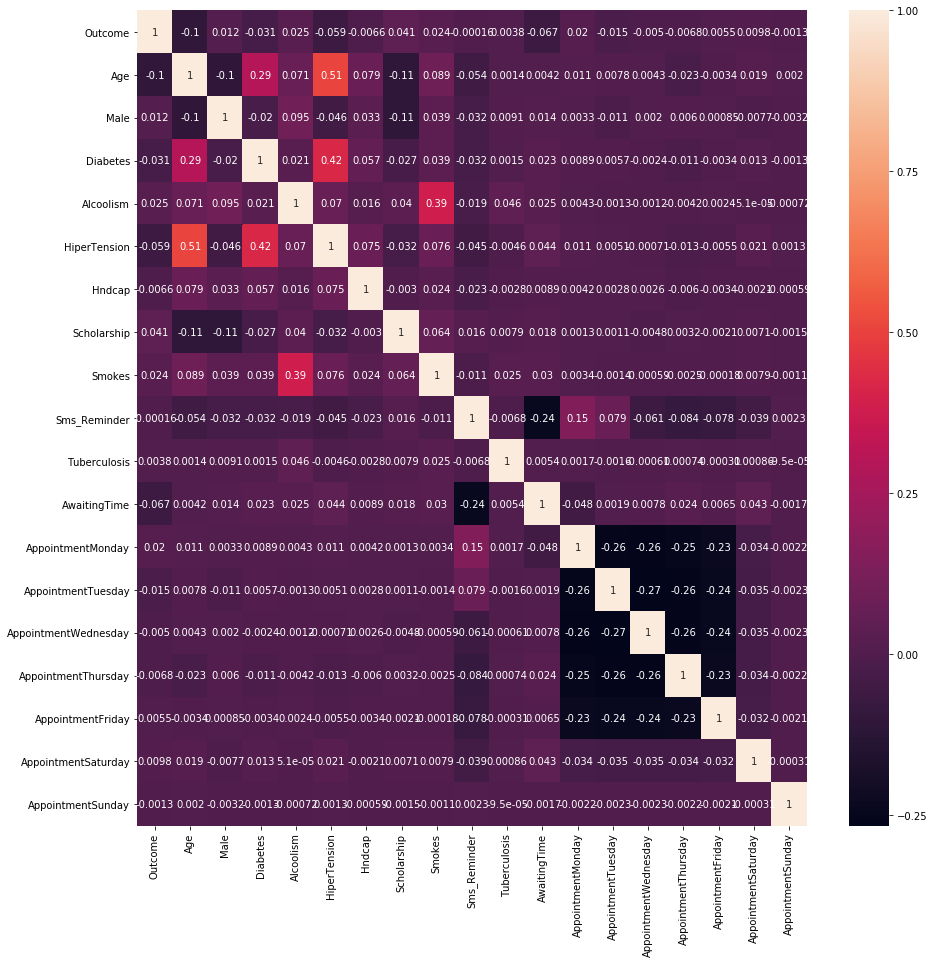

In [8]:
#各列の相関係数を求める
pyplot.figure(figsize = (15,15))
seaborn.heatmap(features_df.corr(), annot = True)

In [9]:
# 説明変数と目的変数の分離
X = features_df.ix[:, 'Age':]
y = features_df['Outcome']

# 学習データとテストデータの分離
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# ランダムフォレストの作成
forest = RandomForestClassifier(min_samples_leaf=3, random_state=0)
forest.fit(X_train, y_train)

##評価
print('Train score: {}'.format(forest.score(X_train, y_train)))
print('Test score: {}'.format(forest.score(X_test,y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test,forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(y_test,forest.predict(X_test))))


/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Train score: 0.7371866666666667
Test score: 0.6835333333333333
Confusion matrix:
[[49200  3147]
 [20588  2065]]
f1 score: 0.148


In [10]:
#説明変数の追加
regs = pd.to_datetime(original_df['AppointmentRegistration'])
features_df['RegistrationMonday'] = regs.apply(lambda r: 1 if r.date().weekday() == 0 else 0)
features_df['RegistrationTuesday'] = regs.apply(lambda r: 1 if r.date().weekday() == 1 else 0)
features_df['RegistrationWednesday'] = regs.apply(lambda r: 1 if r.date().weekday() == 2 else 0)
features_df['RegistrationThursday'] = regs.apply(lambda r: 1 if r.date().weekday() == 3 else 0)
features_df['RegistrationFriday'] = regs.apply(lambda r: 1 if r.date().weekday() == 4 else 0)
features_df['RegistrationSaturday'] = regs.apply(lambda r: 1 if r.date().weekday() == 5 else 0)
features_df['RegistrationSunday'] = regs.apply(lambda r: 1 if r.date().weekday() == 6 else 0)
features_df['RegistrationWorktime'] = regs.apply(lambda r: 1 if r.hour >= 9 and r.hour < 17 else 0)

In [12]:
#重要度の測定と説明変数の削減
x = features_df.ix[:,'Age':]
y = features_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

forest = RandomForestClassifier(random_state = 0)
forest.fit(X_train,y_train)
print('Train score:{:.3f}'.format(forest.score(X_train, y_train)))
print('Test score: {:.3f}'.format(forest.score(X_test,y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test,forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(y_test, forest.predict(X_test))))


Train score:0.804
Test score: 0.647
Confusion matrix:
[[43714  8633]
 [17856  4797]]
f1 score: 0.266


([<matplotlib.axis.YTick at 0x1a18fc9748>,
 <a list of 18 Text yticklabel objects>)

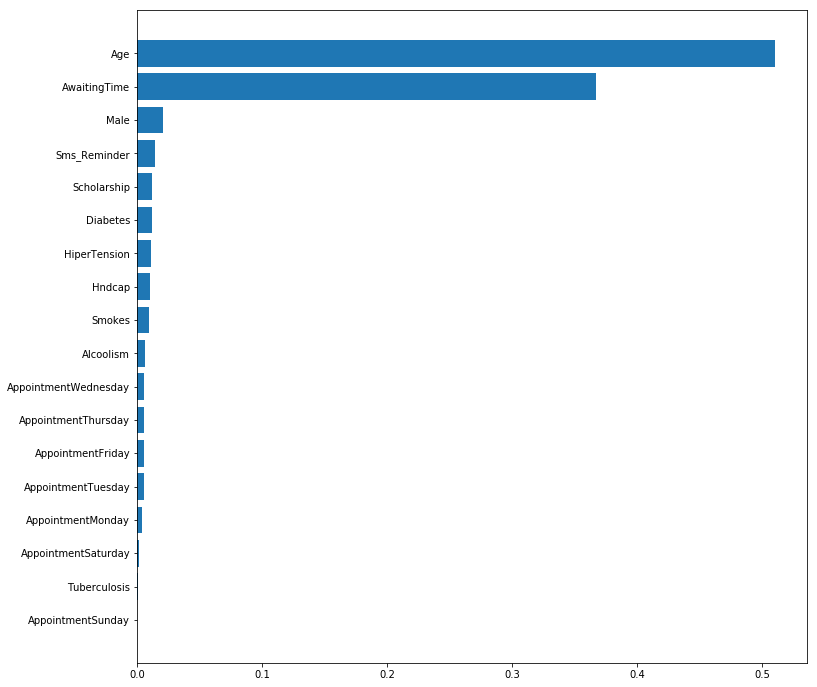

In [13]:
###RandomForestClassifierは、feature_importances_というプロパティを持っており、各説明変数の重要度を持っています。 棒グラフで可視化してみると重要度が高い方からAge、AwaitingTime、Male、・・・と順に続いています。
values, names = zip(*sorted(zip(forest.feature_importances_,X.columns)))
pyplot.figure(figsize = (12,12))
pyplot.barh(range(len(names)) , values, align = 'center')
pyplot.yticks(range(len(names)),names)

In [14]:
features_df.drop(['RegistrationSunday', 'AppointmentSunday', 'Tuberculosis', 'RegistrationSaturday', 'AppointmentSaturday'], axis=1, inplace=True)

In [ ]:
#ハイパーパラメーターの探索
##最後にグリッドサーチでハイパーパラメータを探索します。
###n_estimators: 決定木の数(デフォルトは10)を設定しますが、基本的に多ければ多いほど良くなる(=計算時間とのトレードオフ)なので、今回は10に固定します
###max_features: 各決定木で分類に使用する説明変数の数で、今回は4パターン(1, ‘auto’=全ての説明変数の数の2乗根、None=全ての説明変数の数と同じ)にします
###max_depth: 各決定木の深さを表し、深ければ深いほど複雑な分岐になります(=過学習を起こしやすい)
###min_samples_leaf: 決定木の葉に分類されるサンプル数を決めるパラメータで、3パターン(1, 2, 4)で試します
###今回は、スコア方法をF1にします。 GridSearchCVのscoringオプションで変更できます。 またcv=4として、4グループずつに分けて交差検証します。

###ハイパーパラメーター
forest_grid_param = {
    'n_estimators':[100],
    'max_features':[1,'auto',None],
    'max_depth':[1,5,10,None],
    'min_samples_leaf':[1,2,4,]
}

###スコア方法をF1に設定
# スコア方法をF1に設定
f1_scoring = make_scorer(f1_score,  pos_label=1)

# グリッドサーチで学習
forest_grid_search = GridSearchCV(RandomForestClassifier(random_state=0, n_jobs=-1), forest_grid_param, scoring=f1_scoring, cv=4)
forest_grid_search.fit(X_train, y_train)

# 結果
print('Best parameters: {}'.format(forest_grid_search.best_params_))
print('Best score: {:.3f}'.format(forest_grid_search.best_score_))

/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshis

/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshisui/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/takeisatoshis